## Bert

In [3]:
# !pip install transformers

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
import transformers
import torch
import logging
logging.basicConfig(level=logging.INFO)
from transformers import BertTokenizer, BertForSequenceClassification, BertModel

c:\Users\ADAWAS\miniconda3\envs\pytorch\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
!nvidia-smi

Tue May 23 02:23:07 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 531.14                 Driver Version: 531.14       CUDA Version: 12.1     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                      TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf            Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce GTX 1650       WDDM | 00000000:01:00.0  On |                  N/A |
| N/A   43C    P5                6W /  N/A|    762MiB /  4096MiB |     25%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [4]:
# =============================================================================
# ## check GPU
# =============================================================================
if torch.cuda.is_available():    
    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))
# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: NVIDIA GeForce GTX 1650


In [5]:
# import dataset
df = pd.read_csv(r'https://raw.githubusercontent.com/satyajeetkrjha/kaggle-Twitter-US-Airline-Sentiment-/master/Tweets.csv')[['text','airline_sentiment']]
labelencoder = LabelEncoder()
df['label'] = labelencoder.fit_transform(df['airline_sentiment'])

# df = df.head(1000)
print('Downloading dataset...')
# Report the number of sentences.
print('Number of training sentences: {:,}\n'.format(df.shape[0]))

# Display 10 random rows from the data.
df.sample(10)

Number of training sentences: 14,640



,text,airline_sentiment,label
10521,@USAirways it's been three weeks since I was s...,negative,0
7980,@JetBlue Thanks. Which day of the week is the ...,neutral,1
12633,@AmericanAir you are beyond redemption. Jfk. B...,negative,0
6113,@SouthwestAir Thnx. Hopefully it's just on the...,negative,0
129,@VirginAmerica is flight 882 Cancelled Flightl...,neutral,1
12592,@AmericanAir @BoeingAirplanes I really would l...,positive,2
12160,@AmericanAir how about some rampers at gate b4...,negative,0
10614,@USAirways Sitting on the runway at phl for th...,negative,0
13201,@AmericanAir need help changing a flight. Plea...,neutral,1
6495,@SouthwestAir Any plans to make the southwest ...,negative,0


In [6]:
df.loc[df['label'] == 0].sample(5)[['text','label']]

,text,label
10208,@USAirways took me 4+ hours to book flights ye...,0
2993,@united It is all good -- your 1K team has bee...,0
11140,@USAirways a year and every time with US Air s...,0
10731,@USAirways I know some folks have to use your ...,0
12858,@AmericanAir I fly American because of family ...,0


In [7]:
sentences = df.text.values
labels = df.label.values
sentences, labels

(array(['@VirginAmerica What @dhepburn said.',
        "@VirginAmerica plus you've added commercials to the experience... tacky.",
        "@VirginAmerica I didn't today... Must mean I need to take another trip!",
        ...,
        '@AmericanAir Please bring American Airlines to #BlackBerry10',
        "@AmericanAir you have my money, you change my flight, and don't answer your phones! Any other suggestions so I can make my commitment??",
        '@AmericanAir we have 8 ppl so we need 2 know how many seats are on the next flight. Plz put us on standby for 4 people on the next flight?'],
       dtype=object),
 array([1, 2, 1, ..., 1, 0, 1]))

In [8]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

In [9]:
# Print the original sentence.
print(' Original: ', sentences[0])

# Print the sentence split into tokens.
print('Tokenized: ', tokenizer.tokenize(sentences[0]))
# Print the sentence mapped to token ids.
print('Token IDs: ', tokenizer.convert_tokens_to_ids(tokenizer.tokenize(sentences[0])))

 Original:  @VirginAmerica What @dhepburn said.
Tokenized:  ['@', 'virgin', '##ame', '##rica', 'what', '@', 'dh', '##ep', '##burn', 'said', '.']
Token IDs:  [1030, 6261, 14074, 14735, 2054, 1030, 28144, 13699, 8022, 2056, 1012]


## Special Tokens & Tokenization

In [10]:
text = sentences[0]

# Add the special tokens.
marked_text = "[CLS] " + text + " [SEP]"

# Split the sentence into tokens.
tokenized_text = tokenizer.tokenize(marked_text)

# Map the token strings to their vocabulary indeces.
indexed_tokens = tokenizer.convert_tokens_to_ids(tokenized_text)

# Display the words with their indeces.
for tup in zip(tokenized_text, indexed_tokens):
    print('{:<12} {:>6,}'.format(tup[0], tup[1]))

[CLS]           101
@             1,030
virgin        6,261
##ame        14,074
##rica       14,735
what          2,054
@             1,030
dh           28,144
##ep         13,699
##burn        8,022
said          2,056
.             1,012
[SEP]           102


In [11]:
# show all
print(tokenizer(sentences[0]))
# input_ids
print(tokenizer.encode(sentences[0]))

{'input_ids': [101, 1030, 6261, 14074, 14735, 2054, 1030, 28144, 13699, 8022, 2056, 1012, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}
[101, 1030, 6261, 14074, 14735, 2054, 1030, 28144, 13699, 8022, 2056, 1012, 102]


In [12]:
list(tokenizer.vocab.keys())[5000:5020]

['knight',
 'lap',
 'survey',
 'ma',
 '##ow',
 'noise',
 'billy',
 '##ium',
 'shooting',
 'guide',
 'bedroom',
 'priest',
 'resistance',
 'motor',
 'homes',
 'sounded',
 'giant',
 '##mer',
 '150',
 'scenes']

In [13]:
max_length = 0
for sentence in sentences:
    max_length = max(max_length, len(tokenizer.encode(sentence, add_special_tokens=True)))
    
print('Max sentence length: ', max_length)


Max sentence length:  67


## the old way have data type problem

In [ ]:
input_ids = []
attention_masks = []
for sentence in sentences[:2]:
    encoded_dict = tokenizer.encode_plus(sentence, 
                                         add_special_tokens = True, 
                                         max_length = max_length,
                                         padding='max_length')
    
    input_ids.append(encoded_dict['input_ids'])
    attention_masks.append(encoded_dict['attention_mask'])
    
input_ids = torch.Tensor(input_ids)
attention_masks = torch.Tensor(attention_masks)
labels = torch.Tensor(labels)


# Print sentence 0, now as a list of IDs.
print('Original: ', sentences[0])
print('Token IDs:', input_ids[0])

Original:  @VirginAmerica What @dhepburn said.
Token IDs: tensor([  101.,  1030.,  6261., 14074., 14735.,  2054.,  1030., 28144., 13699.,
         8022.,  2056.,  1012.,   102.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.])


In [ ]:
input_ids[0].dtype, attention_masks[0].dtype, labels[0].dtype

(torch.float32, torch.float32, torch.float32)

## Create new another way torch

In [16]:
input_ids = []
attention_masks = []
for sentence in sentences:
    encoded_dict = tokenizer.encode_plus(sentence, 
                                         add_special_tokens = True, 
                                         max_length = max_length,
                                         padding='max_length',
                                         return_tensors = 'pt')
    
    input_ids.append(encoded_dict['input_ids'])
    attention_masks.append(encoded_dict['attention_mask'])
    
# input_ids = torch.Tensor(input_ids)
# attention_masks = torch.Tensor(attention_masks)
labels = torch.LongTensor(labels)

input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)


# Print sentence 0, now as a list of IDs.
print('Original: ', sentences[0])
print('Token IDs:', input_ids[0])

Original:  @VirginAmerica What @dhepburn said.
Token IDs: tensor([  101,  1030,  6261, 14074, 14735,  2054,  1030, 28144, 13699,  8022,
         2056,  1012,   102,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0])


In [17]:
encoded_dict

{'input_ids': tensor([[  101,  1030, 25988,  4313,  2057,  2031,  1022,  4903,  2140,  2061,
          2057,  2342,  1016,  2113,  2129,  2116,  4272,  2024,  2006,  1996,
          2279,  3462,  1012, 20228,  2480,  2404,  2149,  2006,  3233,  3762,
          2005,  1018,  2111,  2006,  1996,  2279,  3462,  1029,   102,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0

In [18]:
input_ids[0].dtype, attention_masks[0].dtype, labels[0].dtype

(torch.int64, torch.int64, torch.int64)

In [19]:
from torch.utils.data import TensorDataset, random_split, DataLoader, RandomSampler, SequentialSampler

In [20]:
labels

tensor([1, 2, 1,  ..., 1, 0, 1])

## BERT extract word embeding

In [14]:
# Load pre-trained model (weights)
model_wordembeding = BertModel.from_pretrained('bert-base-uncased',
                                  output_hidden_states = True, # Whether the model returns all hidden-states.
                                  )

# Put the model in "evaluation" mode, meaning feed-forward operation.
model_wordembeding.eval()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
  

In [61]:
outputs

BaseModelOutputWithPoolingAndCrossAttentions(last_hidden_state=tensor([[[ 0.0121, -0.0573,  0.3846,  ..., -0.2896,  0.7516,  0.2032],
         [ 1.5905,  0.7797,  0.6360,  ..., -0.0330,  0.8121, -0.5305],
         [ 0.2483, -0.4022,  0.9675,  ..., -0.0609,  0.8803,  0.3074],
         ...,
         [-0.1029, -0.5871,  0.3638,  ...,  0.4781,  0.2898, -0.2760],
         [-0.0617, -0.8215,  0.7895,  ..., -0.0974,  0.3572, -0.2949],
         [ 0.1083, -0.2814,  0.7425,  ...,  0.4173,  0.1751, -0.3131]]],
       grad_fn=<NativeLayerNormBackward0>), pooler_output=tensor([[-0.7686, -0.4204, -0.6821,  0.5972,  0.5583, -0.2323,  0.4389,  0.3393,
         -0.4607, -0.9999,  0.1165,  0.5736,  0.9770,  0.3192,  0.8722, -0.5209,
          0.0439, -0.5390,  0.1786,  0.3740,  0.6138,  1.0000,  0.4436,  0.2134,
          0.4436,  0.8363, -0.6924,  0.9203,  0.9442,  0.6660, -0.5761,  0.1754,
         -0.9871, -0.2651, -0.8694, -0.9867,  0.3187, -0.6044, -0.2055,  0.1117,
         -0.8564,  0.2343,  0.99

In [21]:
# Run the text through BERT, and collect all of the hidden states produced
with torch.no_grad():
    outputs = model_wordembeding(**encoded_dict)

last_hidden_states = outputs.last_hidden_state
last_hidden_states.size(), last_hidden_states

(torch.Size([1, 67, 768]),
 tensor([[[ 0.0121, -0.0573,  0.3846,  ..., -0.2896,  0.7516,  0.2032],
          [ 1.5905,  0.7797,  0.6360,  ..., -0.0330,  0.8121, -0.5305],
          [ 0.2483, -0.4022,  0.9675,  ..., -0.0609,  0.8803,  0.3074],
          ...,
          [-0.1029, -0.5871,  0.3638,  ...,  0.4781,  0.2898, -0.2760],
          [-0.0617, -0.8215,  0.7895,  ..., -0.0974,  0.3572, -0.2949],
          [ 0.1083, -0.2814,  0.7425,  ...,  0.4173,  0.1751, -0.3131]]]))

In [31]:
input_ids = []
attention_masks = []
word_embeding = []
for sentence in sentences[:3]:
    encoded_dict = tokenizer.encode_plus(sentence, 
                                         add_special_tokens = True, 
                                         max_length = max_length,
                                         padding='max_length',
                                         return_tensors = 'pt')
    
    input_ids.append(encoded_dict['input_ids'])
    attention_masks.append(encoded_dict['attention_mask'])
    # Run the text through BERT, and collect all of the hidden states produced
    with torch.no_grad():
       outputs = model_wordembeding(**encoded_dict)

    last_hidden_states = outputs.last_hidden_state
    word_embeding.append(last_hidden_states[0])


labels = torch.LongTensor(labels)

input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)


# Print sentence 0, now as a list of IDs.
print('Original: ', sentences[0])
print('Token IDs:', input_ids[0])
print('Word Embeding:', word_embeding[0])


Original:  @VirginAmerica What @dhepburn said.
Token IDs: tensor([  101,  1030,  6261, 14074, 14735,  2054,  1030, 28144, 13699,  8022,
         2056,  1012,   102,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0])
Word Embeding: tensor([[-0.2078,  0.5304, -0.0119,  ..., -0.5982,  0.7270,  0.4766],
        [ 0.5031,  1.2046, -0.0158,  ..., -0.4413,  0.4110,  0.3713],
        [ 0.1319, -0.0150,  0.0089,  ..., -0.4280, -0.0124, -0.0497],
        ...,
        [ 0.0122,  0.1477,  0.1719,  ..., -0.2122,  0.1645,  0.0500],
        [ 0.2474,  0.2329,  0.2534,  ...,  0.0416,  0.1467,  0.0064],
        [-0.1140, -0.1827,  0.1488,  .

## Training Test Validation Split

In [16]:
# Combine the training inputs into a TensorDataset.
dataset = TensorDataset(input_ids, attention_masks, labels)

# Create a 70-15-15 train-validation-test split.

train_size = int(round(0.7*len(dataset)))
val_size = int(round(0.15*len(dataset)))
test_size = int(round(0.15*len(dataset)))

# Divide the dataset by randomly selecting samples.
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

print('{:,} total samples'.format(len(dataset)))
print('{:,} training samples'.format(len(train_dataset)))
print('{:,} validation samples'.format(len(val_dataset)))
print('{:,} test samples'.format(len(test_dataset)))

14,640 total samples
10,248 training samples
2,196 validation samples
2,196 test samples


In [18]:
# The DataLoader needs to know our batch size for training, so we specify it 
# here. For fine-tuning BERT on a specific task, the authors recommend a batch 
# size of 16 or 32.
# batch_size = 64
batch_size = 8

# Create the DataLoaders for our training and validation sets.
# We'll take training samples in random order. 
train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

# For validation the order doesn't matter, so we'll just read them sequentially.
validation_dataloader = DataLoader(
            val_dataset, # The validation samples.
            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

# For validation the order doesn't matter, so we'll just read them sequentially.
test_dataloader = DataLoader(
            test_dataset, # The validation samples.
            sampler = SequentialSampler(test_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

## Finetune BertModel

In [19]:
from transformers import BertForSequenceClassification, AdamW, BertConfig
# torch.cuda.empty_cache()

# Load BertForSequenceClassification, the pretrained BERT model with a single 
# linear classification layer on top. 
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased",#change model here # Use the 12-layer BERT model, with an uncased vocab.
    num_labels = 3, # The number of output labels--3 for binary classification.
                    # You can increase this for multi-class tasks.   
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
)

# Tell pytorch to run this model on the GPU.
model.cuda()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [20]:
# Get all of the model's parameters as a list of tuples.
params = list(model.named_parameters())

print('The BERT model has {:} different named parameters.\n'.format(len(params)))

print('==== Embedding Layer ====\n')

for p in params[0:5]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== First Transformer ====\n')

for p in params[5:21]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== Output Layer ====\n')

for p in params[-4:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

The BERT model has 201 different named parameters.

==== Embedding Layer ====

bert.embeddings.word_embeddings.weight                  (30522, 768)
bert.embeddings.position_embeddings.weight                (512, 768)
bert.embeddings.token_type_embeddings.weight                (2, 768)
bert.embeddings.LayerNorm.weight                              (768,)
bert.embeddings.LayerNorm.bias                                (768,)

==== First Transformer ====

bert.encoder.layer.0.attention.self.query.weight          (768, 768)
bert.encoder.layer.0.attention.self.query.bias                (768,)
bert.encoder.layer.0.attention.self.key.weight            (768, 768)
bert.encoder.layer.0.attention.self.key.bias                  (768,)
bert.encoder.layer.0.attention.self.value.weight          (768, 768)
bert.encoder.layer.0.attention.self.value.bias                (768,)
bert.encoder.layer.0.attention.output.dense.weight        (768, 768)
bert.encoder.layer.0.attention.output.dense.bias              (

In [21]:
# Note: AdamW is a class from the huggingface library (as opposed to pytorch) 
# I believe the 'W' stands for 'Weight Decay fix"
optimizer = AdamW(model.parameters(),
                  lr = 5e-5, # args.learning_rate - default is 5e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8
                )

c:\Users\ADAWAS\miniconda3\envs\pytorch\lib\site-packages\transformers\optimization.py:407: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [22]:
from transformers import get_linear_schedule_with_warmup

epochs = 4

total_step = len(train_dataloader) * epochs

scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps = 0,
                                            num_training_steps = total_step)

## Train

In [23]:
import datetime
import time
def format_time(elapsed):
    return str(datetime.timedelta(seconds=int(round(elapsed))))

In [24]:
# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [25]:
torch.cuda.empty_cache()

## try

In [45]:
training_stats = []
total_t0 = time.time()

for epoch_i in range(0,epochs):

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    t0 = time.time()
    total_train_loss = 0
    
    model.train()
    for step, batch in enumerate(train_dataloader):
        if step > 0 and step % 40 == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        model.zero_grad()

        outputs = model(b_input_ids,
                          attention_mask=b_input_mask, 
                          labels=b_labels)
        loss = outputs[0]
        total_train_loss += loss.item()

        loss.backward()

        # Clip the norm to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        # update weight
        optimizer.step()
        scheduler.step()
        
    avg_train_loss = total_train_loss / len(train_dataloader)

    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(training_time))
        
    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.
    print("")
    print("Running Validation...")

    t0 = time.time()

    # model.eval()




======== Epoch 1 / 4 ========
Training...
  Batch    40  of    161.    Elapsed: 0:00:00.
  Batch    80  of    161.    Elapsed: 0:00:01.
  Batch   120  of    161.    Elapsed: 0:00:01.
  Batch   160  of    161.    Elapsed: 0:00:02.

  Average training loss: 0.01
  Training epcoh took: 0:00:02

Running Validation...

======== Epoch 2 / 4 ========
Training...
  Batch    40  of    161.    Elapsed: 0:00:00.
  Batch    80  of    161.    Elapsed: 0:00:01.
  Batch   120  of    161.    Elapsed: 0:00:01.
  Batch   160  of    161.    Elapsed: 0:00:02.

  Average training loss: 0.01
  Training epcoh took: 0:00:02

Running Validation...

======== Epoch 3 / 4 ========
Training...
  Batch    40  of    161.    Elapsed: 0:00:00.
  Batch    80  of    161.    Elapsed: 0:00:01.
  Batch   120  of    161.    Elapsed: 0:00:01.
  Batch   160  of    161.    Elapsed: 0:00:02.

  Average training loss: 0.01
  Training epcoh took: 0:00:02

Running Validation...

======== Epoch 4 / 4 ========
Training...
  Batch  

## answers

In [26]:
# We'll store a number of quantities such as training and validation loss, 
# validation accuracy, and timings.
training_stats = []

# Measure the total training time for the whole run.
total_t0 = time.time()

# For each epoch...
for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    
    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_train_loss = 0

    model.train()
    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Unpack this training batch from our dataloader. 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].type(torch.LongTensor).to(device)

        model.zero_grad()        

        out           = model(b_input_ids,
                             attention_mask=b_input_mask, 
                             labels=b_labels)

        total_train_loss += out[0].item()

        out[0].backward()

        # Clip the norm to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        # update weight
        optimizer.step()
        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)            
    
    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(training_time))
        
    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.
    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()

    # Tracking variables 
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].type(torch.LongTensor).to(device)
        
        # Tell pytorch not to bother with constructing the compute graph during
        # the forward pass, since this is only needed for backprop (training).
        with torch.no_grad():        

            out            = model(b_input_ids, 
                                   attention_mask=b_input_mask,
                                   labels=b_labels)
            
        # Accumulate the validation loss.
        total_eval_loss += out[0].item()

        # Move logits and labels to CPU
        logits = out[1].detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences, and
        # accumulate it over all batches.
        total_eval_accuracy += flat_accuracy(logits, label_ids)
        

    # Report the final accuracy for this validation run.
    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

    # Calculate the average loss over all of the batches.
    avg_val_loss = total_eval_loss / len(validation_dataloader)
    
    # Measure how long the validation run took.
    validation_time = format_time(time.time() - t0)
    
    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 4 ========
Training...
  Batch    40  of  1,281.    Elapsed: 0:00:20.
  Batch    80  of  1,281.    Elapsed: 0:00:33.
  Batch   120  of  1,281.    Elapsed: 0:00:45.
  Batch   160  of  1,281.    Elapsed: 0:00:59.
  Batch   200  of  1,281.    Elapsed: 0:01:12.
  Batch   240  of  1,281.    Elapsed: 0:01:25.
  Batch   280  of  1,281.    Elapsed: 0:01:43.
  Batch   320  of  1,281.    Elapsed: 0:02:00.
  Batch   360  of  1,281.    Elapsed: 0:02:16.
  Batch   400  of  1,281.    Elapsed: 0:02:33.
  Batch   440  of  1,281.    Elapsed: 0:02:50.
  Batch   480  of  1,281.    Elapsed: 0:03:06.
  Batch   520  of  1,281.    Elapsed: 0:03:23.
  Batch   560  of  1,281.    Elapsed: 0:03:40.
  Batch   600  of  1,281.    Elapsed: 0:03:56.
  Batch   640  of  1,281.    Elapsed: 0:04:13.
  Batch   680  of  1,281.    Elapsed: 0:04:29.
  Batch   720  of  1,281.    Elapsed: 0:04:46.
  Batch   760  of  1,281.    Elapsed: 0:05:03.
  Batch   800  of  1,281.    Elapsed: 0:05:19.
  Batch   840  of

In [27]:
# Create a DataFrame from our training statistics.
df_stats = pd.DataFrame(data=training_stats)

# Use the 'epoch' as the row index.
df_stats = df_stats.set_index('epoch')

# Display the table.
df_stats

,Training Loss,Valid. Loss,Valid. Accur.,Training Time,Validation Time
epoch,,,,,
1,0.529470,0.525645,0.829091,0:08:40,0:00:37
2,0.335063,0.510805,0.844545,0:09:07,0:00:36
3,0.182522,0.784870,0.837727,0:09:03,0:00:35
4,0.088640,0.823965,0.846364,0:09:06,0:00:37


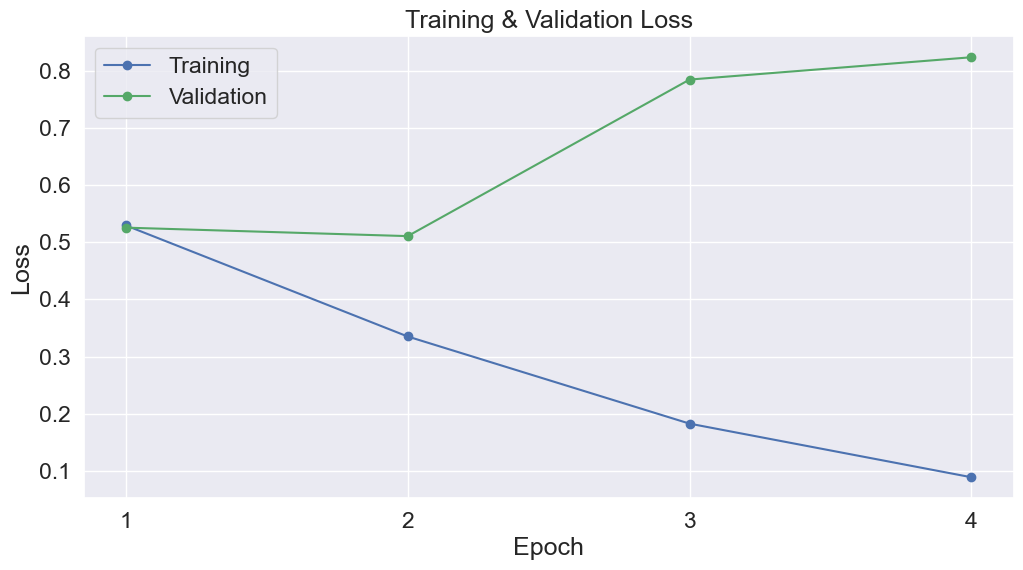

In [28]:
# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4])

plt.show()